# Homework 2 - Algorithmic Methods of Data Mining

### Author: Viktoriia Vlasenko  
**University Email:** [vlasenko.2088928@studenti.uniroma1.it](mailto:vlasenko.2088928@studenti.uniroma1.it)

---


# Research questions (RQs)

## Research Question 1

[**RQ1**]  Before diving deep into the dataset provided, it's crucial to understand its structure and main features. Data scientists usually take the first step of performing an Exploratory Data Analysis (EDA). What can you say about our dataset? Please perform an EDA and summarize the dataset's key characteristics using visualizations and tabular summaries.

**Importing the required libraries for EDA**

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy.signal import find_peaks
from scipy.stats import pearsonr, spearmanr, chi2_contingency, kruskal
import warnings
sns.set(color_codes=True)

In [4]:
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [5]:
# I want pastel plots style
plt.style.use('seaborn-v0_8-pastel')

**Loading the data into the data frame**

A custom implementation of date parser. This parser will be used in reading the data row by row.

In [6]:
def date_parse(time_in_secs):
  return pd.to_datetime(pd.to_numeric(time_in_secs), unit='s')

I'm using the parser for 3 columns `["timestamp_created", "timestamp_updated", "author.last_played"]` that contain datetime formatated values.

To resolve an issue with reading big dataset I created a logic with reading a dataset in chunks. Apx. 1 chunk with size of 1M records is elaborated in 6.6 minutes (400 seconds). Since the dataset contains 21M records which will be read in $6.6 * 21 = 140 mins = 2.3 hours$.

In [7]:
chunksize = 1000000
print(f"Chunk size: {chunksize}")
all_chunks = []

# Start timer to evaluate time of reading the dataset and merging chunks all together
start_time = time.time()
start_chunk_time = start_time

# Read the CSV file in chunks
for i, chunk in enumerate(pd.read_csv("/kaggle/input/steam-reviews-2021/steam_reviews.csv",
                                      chunksize=chunksize,
                                      header="infer",
                                      # For this hw I need 15 columns out of 23
                                      usecols=[
                                          'app_id', 
                                          'app_name', 
                                          'review_id', 
                                          'language', 
                                          'review',
                                          'timestamp_created',
                                          'timestamp_updated', 
                                          'recommended', 
                                          'votes_helpful', 
                                          'weighted_vote_score', 
                                          'received_for_free', 
                                          'author.steamid', 
                                          'author.num_games_owned', 
                                          'author.num_reviews', 
                                          'author.playtime_forever'],
                                      converters={
                                          "timestamp_created": date_parse,
                                          "timestamp_updated": date_parse,
                                          "author.last_played": date_parse})):

    # Add current chunk to chunks list
    all_chunks.append(chunk)

    # Calculate time of reading current chunk
    end_chunk_time = time.time()
    print(f"Chunk {i + 1} was loaded in {(end_chunk_time - start_chunk_time) / 60} mins")
    start_chunk_time = end_chunk_time

print("----------------------------")
# Calculate total time of reading all chunks
print(f"Total reading time: {(time.time() - start_time) / 60} mins")

# Concatenate all processed chunks into a single DataFrame
concat_start_time = time.time()
# Main dataframe
stream_reviews = pd.concat(all_chunks)

# Calculate total time of concatenation of chunks
print(f"Chunk concatenation time: {time.time() - concat_start_time} secs")

# Print shape of read dataset
print(stream_reviews.shape)

Chunk size: 1000000
Chunk 1 was loaded in 4.83645750284195 mins
Chunk 2 was loaded in 4.725978688398997 mins
Chunk 3 was loaded in 4.800575737158457 mins
Chunk 4 was loaded in 4.780520129203796 mins
Chunk 5 was loaded in 4.826883784929911 mins
Chunk 6 was loaded in 4.763257416089376 mins
Chunk 7 was loaded in 4.729923756917318 mins
Chunk 8 was loaded in 4.731179447968801 mins
Chunk 9 was loaded in 4.832030812899272 mins
Chunk 10 was loaded in 4.7831370035807295 mins
Chunk 11 was loaded in 4.774936699867249 mins
Chunk 12 was loaded in 4.78249001900355 mins
Chunk 13 was loaded in 4.8332182248433435 mins
Chunk 14 was loaded in 4.727705589930216 mins
Chunk 15 was loaded in 4.728169484933217 mins
Chunk 16 was loaded in 4.7838491082191466 mins
Chunk 17 was loaded in 4.871065918604533 mins
Chunk 18 was loaded in 4.929267466068268 mins
Chunk 19 was loaded in 4.744835146268209 mins
Chunk 20 was loaded in 4.75516687631607 mins
Chunk 21 was loaded in 4.812974834442139 mins
Chunk 22 was loaded in 

I decided to load few columns from the dataset and my total reading time shorten from 2h 20mins to 1h 44mins.

**Basic information about the dataset**

The dataset has 23 columns but I read only 14 of them to reduce time of loading of dataframe into a notebook. The imported columns have the following datatypes:

In [8]:
print("Number of rows:", stream_reviews.shape[0])
print("Number of columns:", stream_reviews.shape[1])
print("Columns:")
print(stream_reviews.columns)
print("Data Types:")
print(stream_reviews.dtypes)

Number of rows: 21747371
Number of columns: 15
Columns:
Index(['app_id', 'app_name', 'review_id', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'recommended',
       'votes_helpful', 'weighted_vote_score', 'received_for_free',
       'author.steamid', 'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever'],
      dtype='object')
Data Types:
app_id                              int64
app_name                           object
review_id                           int64
language                           object
review                             object
timestamp_created          datetime64[ns]
timestamp_updated          datetime64[ns]
recommended                          bool
votes_helpful                       int64
weighted_vote_score               float64
received_for_free                    bool
author.steamid                      int64
author.num_games_owned              int64
author.num_reviews                  int64
author.playtime_fo

Using the `head` or `tail` (or as alternative print dataset directly: gives first 5 and last 5 rows) function it is possible to see the samples of the data in the dataframe. It helps to verify correctness of reading and parsing data (parsing datetime values or excluding indexing columns and right definition of the header row with names of the columns).

In [9]:
stream_reviews.head(3)

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,weighted_vote_score,received_for_free,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever
0,292030,The Witcher 3: Wild Hunt,85185598,schinese,不玩此生遗憾，RPG游戏里的天花板，太吸引人了,2021-01-23 06:00:29,2021-01-23 06:00:29,True,0,0.0,False,76561199095369542,6,2,1909.0
1,292030,The Witcher 3: Wild Hunt,85185250,schinese,拔DIAO无情打桩机--杰洛特!!!,2021-01-23 05:50:30,2021-01-23 05:50:30,True,0,0.0,False,76561198949504115,30,10,2764.0
2,292030,The Witcher 3: Wild Hunt,85185111,schinese,巫师3NB,2021-01-23 05:46:40,2021-01-23 05:46:40,True,0,0.0,False,76561199090098988,5,1,1061.0


The dataframe's function `describe` represents the basic statistical

computations over numeric data on the dataset. The dataset has 2 columns `["author.num_games_owned", "author.num_reviews"]` that could be easily described and with this approach. The count is equal to the total number of read records from the csv file.



Also it is showing great statistical overview about users of the Stream platform that are playing games and publishing their review abot their gaming experience.

In [10]:
round(stream_reviews[["author.num_games_owned", "author.num_reviews"]].describe(), 1)

,author.num_games_owned,author.num_reviews
count,2.174737e+07,2.174737e+07
mean,1.011300e+06,4.044775e+05
std,2.108829e+09,1.333741e+09
min,0.000000e+00,1.000000e+00
25%,2.200000e+01,2.000000e+00
50%,6.100000e+01,4.000000e+00
75%,1.450000e+02,1.000000e+01
max,4.398047e+12,4.398047e+12


**Missing Values**

As it shown there are few missing values of `"review"`, `"author.playtime_at_review"` and others. "Few" in meaning to the total number of the records in the dataframe. Also on kaggle page of the dataset it is present information about missing values in each column. The major part of them is in the column `"review"`.

In [11]:
stream_reviews.isna().sum()

app_id                         0
app_name                       0
review_id                      0
language                       0
review                     33748
timestamp_created              0
timestamp_updated              0
recommended                    0
votes_helpful                  0
weighted_vote_score            0
received_for_free              0
author.steamid                 0
author.num_games_owned         0
author.num_reviews             0
author.playtime_forever        2
dtype: int64

To manage missing values it is used `dropna` function. `dropna` removes rows with NaN values that helps to clean the data for further analysis.

In [12]:
# Print shape of dataframe before dropping missing values
print(stream_reviews.shape)
stream_reviews.dropna(inplace=True)

(21747371, 15)


By removing rows with missing values using dropna(), the dataset is now more suitable for accurate analysis and representation.

In [13]:
stream_reviews.isna().sum()

app_id                     0
app_name                   0
review_id                  0
language                   0
review                     0
timestamp_created          0
timestamp_updated          0
recommended                0
votes_helpful              0
weighted_vote_score        0
received_for_free          0
author.steamid             0
author.num_games_owned     0
author.num_reviews         0
author.playtime_forever    0
dtype: int64

Now the dataset is clean and ready. Let's verify the new shape:

In [14]:
stream_reviews.shape

(21713621, 15)

**Infinite values handling**

Replace all infinite values to Nan to avoid a warning:
>  FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.  with pd.option_context('mode.use_inf_as_na', True):

In [15]:
stream_reviews.replace([np.inf, -np.inf], np.nan, inplace=True)

**Check application ids**

Let's check if there is a case when `app_name` could have different `app_id`.

In [16]:
duplicate_names = stream_reviews.groupby('app_name')['app_id'].nunique()
duplicate_names = duplicate_names[duplicate_names > 1]

if len(duplicate_names) > 0:
    print("The following app names have multiple app IDs:")
    for app_name, count in duplicate_names.items():
        print(f"- {app_name}: {count} different app IDs")
else:
    print("All app names have unique app IDs.")

All app names have unique app IDs.


So for further analysis it can be used either `app_id` or `app_name` as application identifier.

**Data visualization**

To visualise the data I choose to show number of positive recommentations by language.

language
english      8568121
schinese     2900456
russian      2092693
brazilian     790015
spanish       754251
german        664309
turkish       573205
koreana       516059
french        488134
polish        467229
Name: recommended, dtype: int64


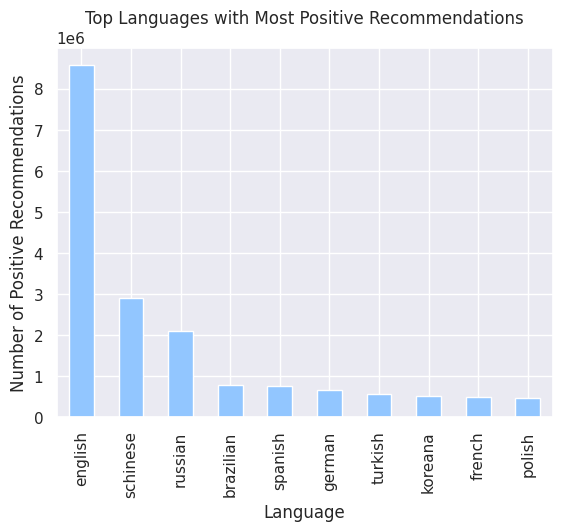

In [17]:
# Count positive recomendations in grouped by language dataframe
language_recommendations = stream_reviews[stream_reviews['recommended'] == True].groupby('language')['recommended'].count()

# Sort
language_recommendations = language_recommendations.sort_values(ascending=False)

# Print the top 10 languages
print(language_recommendations.head(10))

language_recommendations.head(10).plot(kind='bar')
plt.title('Top Languages with Most Positive Recommendations')
plt.xlabel('Language')
plt.ylabel('Number of Positive Recommendations')
plt.show()

Also it is interesting to see negative side of recomendations.

language
english      1050560
schinese      861880
russian       253387
koreana        96914
german         86315
turkish        61861
spanish        58355
french         51327
brazilian      46873
tchinese       36090
Name: recommended, dtype: int64


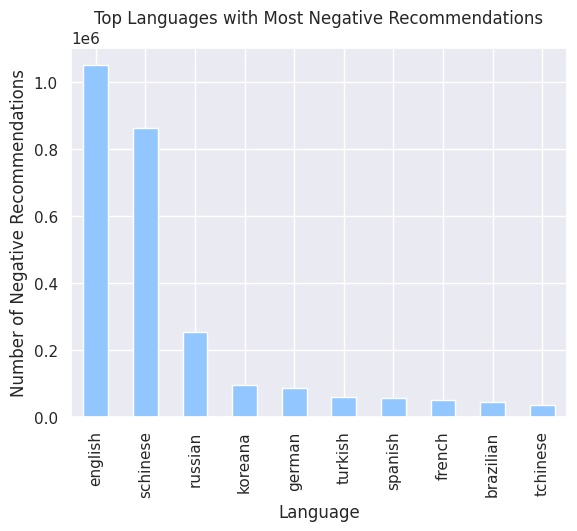

In [18]:
# Count positive recomendations in grouped by language dataframe
language_recommendations = stream_reviews[stream_reviews['recommended'] == False].groupby('language')['recommended'].count()

# Sort
language_recommendations = language_recommendations.sort_values(ascending=False)

# Print the top 10 languages
print(language_recommendations.head(10))

language_recommendations.head(10).plot(kind='bar')
plt.title('Top Languages with Most Negative Recommendations')
plt.xlabel('Language')
plt.ylabel('Number of Negative Recommendations')
plt.show()

As it is shown top 3 languages are the same that could significate the large population of the reviews written in these languages.

## Research Question 2

[**RQ2**] *Let's explore the dataset by analyzing the distribution of reviews across different applications.*

   - Identify which applications have the highest and lowest number of reviews.

   - Plot the number of reviews for each application in descending order. What insights can you draw from the plot?

   - For the top 5 applications by number of reviews, how many reviews came from users who purchased the application versus those who received it for free? Provide a percentage breakdown and highlight any similarities.

   - Which applications have the most and the least user recommendations? Summarize your findings.

   - Is there a correlation between the number of recommendations and the applications' review scores? Use a statistical test to confirm the significance of the relationship.

**Identify which applications have the highest and lowest number of reviews.**

In [19]:
# Count number of reviews for an application
app_review_counts = stream_reviews.groupby('app_name')['review_id'].count()

# Find highest and lowest reviewd applications
highest = app_review_counts.idxmax()
lowest = app_review_counts.idxmin()

print(f"The application that have the highest number of reviews -> {highest}")
print(f"The application that have the lowest number of reviews -> {lowest}")

The application that have the highest number of reviews -> PLAYERUNKNOWN'S BATTLEGROUNDS
The application that have the lowest number of reviews -> Neon Hardcorps


**Plot the number of reviews for each application in descending order. What insights can you draw from the plot?**

(315,)


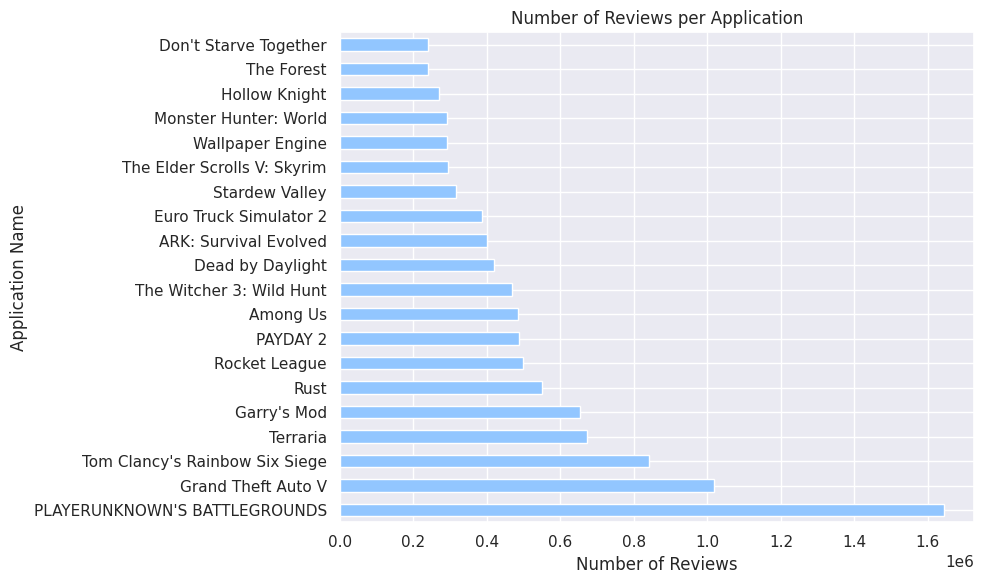

In [20]:
# Sort of app_review_counts in desc order
sorted_app_reviews = app_review_counts.sort_values(ascending=False)
print(sorted_app_reviews.shape)

# Plot the sorted review counts
plt.figure(figsize=(10, 6))
# Since there are 315 applications and 
# there is no way to plot is without overlaping the labels 
# I choose to plot top 20 of them
sorted_app_reviews.head(20).plot(kind='barh')
plt.title("Number of Reviews per Application")
plt.ylabel("Application Name")
plt.xlabel("Number of Reviews")
plt.tight_layout()
plt.show()

**For the top 5 applications by number of reviews, how many reviews came from users who purchased the application versus those who received it for free? Provide a percentage breakdown and highlight any similarities.**

In [21]:
# For printing numbers for each application in top 5 I created a function
def print_application_stats(app_name: str, total: int, purchased: int, free: int):
    print(f"- Total number of reviews of '{app_name}': {total}")
    print(f"- Total number of reviews came from users who purchased the application '{app_name}': {purchased}")
    print(f"- Total number of reviews came from users who received it for free: {free}")
    # Print application percentages
    print(f"- Percentage of reviews from users that obtained an app for free: {percentage(free, total)}")
    print(f"- Percentage of reviews from users that purchased an app: {percentage(purchased, total)}")
    print("---------------------------")


# Function for printing the percentage of part from total
def percentage(part, total):
    # Division by zero check
    if total == 0: return "0%"
    return f"{(100 * float(part)/float(total)):.2f}%"

# Top 5 applications by review count
top5 = sorted_app_reviews.head(5).index
# print(top5)

# Filter the dataset to contain only data for applications in top5
top5_df = stream_reviews[stream_reviews['app_name'].isin(top5)]
# print(top5_df)

# I'm using dictionary to store info from iteration top5 applications
# If I had to analyse bigger amount of applications, I would choose another approach
top5_stats = { 'total': 0, 'free': 0, 'purchased': 0}

# Iterate top5 applications: print stats for each application
for app_name, app_df in top5_df.groupby('app_name'):
    print(f"Application: {app_name}")
    # Calculate total numbers of reviews for an aplication, number of them received for free and purchased
    total = app_df['review_id'].count()
    free = app_df[app_df['received_for_free'] == True]['review_id'].count()
    purchased = app_df[app_df['received_for_free'] == False]['review_id'].count()

    # Store totals into totals of top5
    top5_stats['total'] += total
    top5_stats['free'] += free
    top5_stats['purchased'] += purchased

    # Print stats for each application
    print_application_stats(app_name, total, purchased, free)

# ----------------------------------

# Conclusion
print(f"Total reviews for top 5 applications: {top5_stats['total']}")
print(f"Percentage of reviews from users that obtained an app for free for top 5 applications: {percentage(top5_stats['free'], top5_stats['total'])}")
print(f"Percentage of reviews from users that purchased an app for top 5 applications: {percentage(top5_stats['purchased'], top5_stats['total'])}")

Application: Garry's Mod
- Total number of reviews of 'Garry's Mod': 654511
- Total number of reviews came from users who purchased the application 'Garry's Mod': 629763
- Total number of reviews came from users who received it for free: 24748
- Percentage of reviews from users that obtained an app for free: 3.78%
- Percentage of reviews from users that purchased an app: 96.22%
---------------------------
Application: Grand Theft Auto V
- Total number of reviews of 'Grand Theft Auto V': 1017313
- Total number of reviews came from users who purchased the application 'Grand Theft Auto V': 978719
- Total number of reviews came from users who received it for free: 38594
- Percentage of reviews from users that obtained an app for free: 3.79%
- Percentage of reviews from users that purchased an app: 96.21%
---------------------------
Application: PLAYERUNKNOWN'S BATTLEGROUNDS
- Total number of reviews of 'PLAYERUNKNOWN'S BATTLEGROUNDS': 1643246
- Total number of reviews came from users who p

According to the calculated percentages the proportion between number of reviews that came from users that purchased an application and obtained it for free for the top 5 reviewed applications is quite similar.
| # | Application name | Purchased % | Free % | Total |
|--------------|------------|------------|------------|------------|
| 1 | PLAYERUNKNOWN'S BATTLEGROUNDS | 96.26% | 3.74% | 1642631 |
| 2 | Grand Theft Auto V | 96.21% | 3.79% | 1016370 |
| 3 | Tom Clancy's Rainbow Six Siege | 95.69% | 4.31% | 839838 |
| 4 | Terraria | 97.00% | 3.00% | 671425 |
| 5 | Garry's Mod | 96.22% | 3.78% | 653815 |

**Which applications have the most and the least user recommendations? Summarize your findings.**

By an assumption the application has the most user recommendations when has a <u>*max positive recommended vote*</u> (`recommended` is **True**). The application has the least user recommendations when has a <u>*max negative recommended vote*</u> (`recommended` is **False**).

In [22]:
# Function that filter reviews as they recommended or not (True or False)
def get_application_by_recommendation(recommended_status=True):
    # Filter reviews
    filtered_reviews = stream_reviews[stream_reviews['recommended'] == recommended_status]
    
    # Total number of recommended or not recommended reviews
    recommendation_counts = filtered_reviews.groupby('app_name').size()

    # case: recommended is True (calculate the most users' recommended application)
    if recommended_status:
        app_name = recommendation_counts.idxmax()
        count = recommendation_counts.max()
        print(f"The application that have the most user recommendations -> ({app_name}, {count})")
    # case: recommended is False (calculate the least users' recommended application)
    else:
        app_name = recommendation_counts.idxmax()
        count = recommendation_counts.max()
        print(f"The application that have the least user recommendations -> ({app_name}, {count})")

get_application_by_recommendation(True)
get_application_by_recommendation(False)

The application that have the most user recommendations -> (PLAYERUNKNOWN'S BATTLEGROUNDS, 885546)
The application that have the least user recommendations -> (PLAYERUNKNOWN'S BATTLEGROUNDS, 757700)


<u>"PLAYERUNKNOWN'S BATTLEGROUNDS"</u> has the most and the least user recommendations.

**Is there a correlation between the number of recommendations and the applications' review scores? Use a statistical test to confirm the significance of the relationship.**

For discovering a correlation between the number of recommendations and the applications' review scores I choose two statistical tests to confirm the significance of the relationship: <u>the Pearson</u> and <u>the Spearman</u> correlations.

Pearson correlation: -0.3030074732289437
Pearson P-value: 4.111972332783799e-08
Spearman correlation: -0.6256082437812664
Spearman P-value: 1.2733562743428347e-35


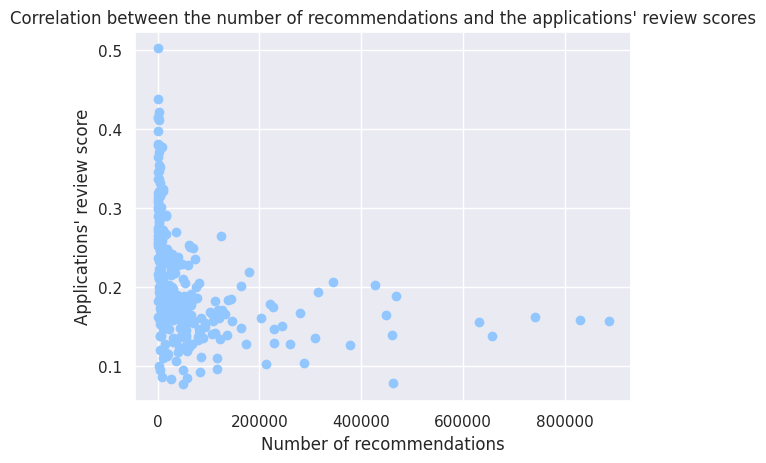

In [23]:
# Find the total number of reviews and average weighted_vote_score for each application
app_stats = stream_reviews.groupby('app_name').agg({'recommended': 'sum', 'weighted_vote_score': 'mean'})

# Calculate the Pearson correlation
pearson_r, pearson_p = pearsonr(app_stats['recommended'], app_stats['weighted_vote_score'])
print(f"Pearson correlation: {pearson_r}")
print(f"Pearson P-value: {pearson_p}")

# Calculate the Spearman correlation
spearman_r, spearman_p = spearmanr(app_stats['recommended'], app_stats['weighted_vote_score'])
print(f"Spearman correlation: {spearman_r}")
print(f"Spearman P-value: {spearman_p}")

plt.scatter(app_stats['recommended'], app_stats['weighted_vote_score'])
plt.xlabel('Number of recommendations')
plt.ylabel("Applications' review score")
plt.title("Correlation between the number of recommendations and the applications' review scores")
plt.show()

**Statistical tests**

**Pearson Correlation**
* *Null Hypothesis $H_0$*: There is no linear correlation between the number of recommendations and the review scores ($p = 0$).
* *Alternative Hypothesis $H_1$*: There is a linear correlation between the number of recommendations and the review scores ($p \neq 0$).

<u>The Pearson correlation coefficient</u> $r = -0.3$. The Pearson correlation coefficient measures the strength and direction of the relationship between two variables. The obtained value indicates on a moderate negative linear relationship between the number of recommendations and applications' review scores. As the number of recommendations increases, the average review scores tend to decrease.

<u>P-value</u> $p = 4.1283288832810826e-08 < 0.05$ that rejects the null hypothesis in favor of the alternative. The correlation is statically significant. There is a linear relationship between the number of recommendations and applications' review scores in the population at the $α = 0.05$ level.


**Spearman Correlation**
* *Null Hypothesis $H_0$*: There is no monotonic correlation between the number of recommendations and the review scores ($p = 0$).
* *Alternative Hypothesis $H_1$*: There is a monotonic correlation between the number of recommendations and the review scores ($p \neq 0$).

<u>The Spearman correlation coefficient</u> $r_s = -0.6$. The Spearman correlation coefficient measures the strength and direction of the monotonic relationship between two ranked variables. The obtained value strong negative monotonic relationship between the number of recommendations and applications' review scores. As the number of recommendations increases, the review scores consistently decrease.

<u>P-value</u> $p = 1.182368568550798e-35 < 0.05$ that rejects the null hypothesis in favor of the alternative. The correlation is statically significant. There is a monotonic relationship between the number of recommendations and applications' review scores in the population at the $α = 0.05$ level.

**Conclusion**

Since Alternative Hypothesis $H_1$ is valid for both statistical tests there is no evidence of a perfect linear or monotonic association (even thouh the Spearman correlation coefficient is showing stronger relationship), but in both cases there is pattern of decreasing the applications' review scores with increasing the number of recommendations.


**Sources**
* The Pearson correlation coefficient: https://www.scribbr.com/statistics/pearson-correlation-coefficient/
* The Pearson p-value: https://towardsdatascience.com/eveything-you-need-to-know-about-interpreting-correlations-2c485841c0b8
* The Spearman rank correlation: https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient


## Research Question 3

[**RQ3**] *Understanding when users are most active in submitting reviews can help identify peak engagement periods.*

   - Plot the number of reviews submitted each month and describe any trends.

   - Identify any seasonal patterns or trends in review activity. Explain any seasonal impact you notice.

   - Determine if certain times of the year have higher engagement rates. Describe noticeable peaks in user activity.

   - What is the most common time of day users write reviews? For example, users might typically write reviews at 17:44. Explain how this time distribution could influence your analysis.

   - Create a function that accepts a list of time intervals and plots the number of reviews for each interval.

   - Use the function to plot the number of reviews for the following time intervals:


| Initial Time | Final Time |
|--------------|------------|
| 00:00:00     | 02:59:59   |
| 03:00:00     | 05:59:59   |
| 06:00:00     | 10:59:59   |
| 11:00:00     | 13:59:59   |
| 14:00:00     | 16:59:59   |
| 17:00:00     | 19:59:59   |
| 20:00:00     | 23:59:59   |


   - Summarize your findings from the time interval analysis.

**Plot the number of reviews submitted each month and describe any trends.**

Let's assume that there is present seasonal trend of users' activity. Therefore months can be agregated to see distribution of activity.

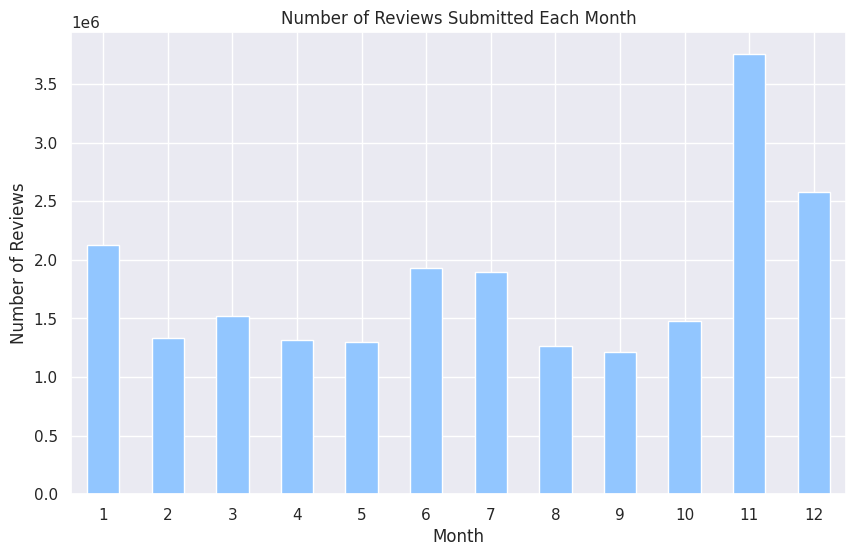

In [24]:
# 1. Count number of reviews in grouprd by month dataframe
# 2. Plot result
stream_reviews.groupby(stream_reviews['timestamp_created'].dt.month)['review_id'].count().plot(kind='bar', figsize=(10, 6))

plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Submitted Each Month')
plt.xticks(rotation=0)
plt.show()

Visually there are present peaks on summer and winter months.

**Identify any seasonal patterns or trends in review activity. Explain any seasonal impact you notice.**

To analyse results that colud be different from year to year I decided to plot each year separately.

In [25]:
# Define datetime format for further analysis of month/year impact on reviews
datetime_format = "%Y/%m"

# Create a new Series with the month and year
month_year_series = stream_reviews['timestamp_created'].dt.strftime(datetime_format)

# Group by the month_year_series and count reviews
monthly_reviews = stream_reviews.groupby(month_year_series, observed=False)['review_id'].count()

# Store the data by years:
# - key is a year
# - value is another dictionary inside that contains numbers of reviews
# that were published in current month
monthly_reviews_dict = {}

# Iterate through the monthly_reviews Series
for date, reviews in monthly_reviews.items():
    year = pd.to_datetime(date, format=datetime_format).year
    month = pd.to_datetime(date, format=datetime_format).strftime('%m')
    # Add data to the dictionary
    if year not in monthly_reviews_dict:
        monthly_reviews_dict[year] = {}
    monthly_reviews_dict[year][month] = reviews

In [26]:
for year in sorted(monthly_reviews_dict.keys()):
    months = monthly_reviews_dict[year]
    print(f"Year {year} has {len(months)} months: ")
    for month, reviews in months.items():
        print(f"- Month: {month}, Reviews: {reviews}")

Year 2010 has 2 months: 
- Month: 11, Reviews: 555
- Month: 12, Reviews: 1815
Year 2011 has 12 months: 
- Month: 01, Reviews: 824
- Month: 02, Reviews: 577
- Month: 03, Reviews: 590
- Month: 04, Reviews: 1811
- Month: 05, Reviews: 1586
- Month: 06, Reviews: 1247
- Month: 07, Reviews: 5051
- Month: 08, Reviews: 1507
- Month: 09, Reviews: 1032
- Month: 10, Reviews: 1288
- Month: 11, Reviews: 3095
- Month: 12, Reviews: 12391
Year 2012 has 12 months: 
- Month: 01, Reviews: 3503
- Month: 02, Reviews: 1843
- Month: 03, Reviews: 1761
- Month: 04, Reviews: 1498
- Month: 05, Reviews: 1873
- Month: 06, Reviews: 1858
- Month: 07, Reviews: 11703
- Month: 08, Reviews: 3740
- Month: 09, Reviews: 3936
- Month: 10, Reviews: 3329
- Month: 11, Reviews: 4453
- Month: 12, Reviews: 8236
Year 2013 has 12 months: 
- Month: 01, Reviews: 7208
- Month: 02, Reviews: 4381
- Month: 03, Reviews: 7603
- Month: 04, Reviews: 7631
- Month: 05, Reviews: 6217
- Month: 06, Reviews: 7657
- Month: 07, Reviews: 14960
- Month

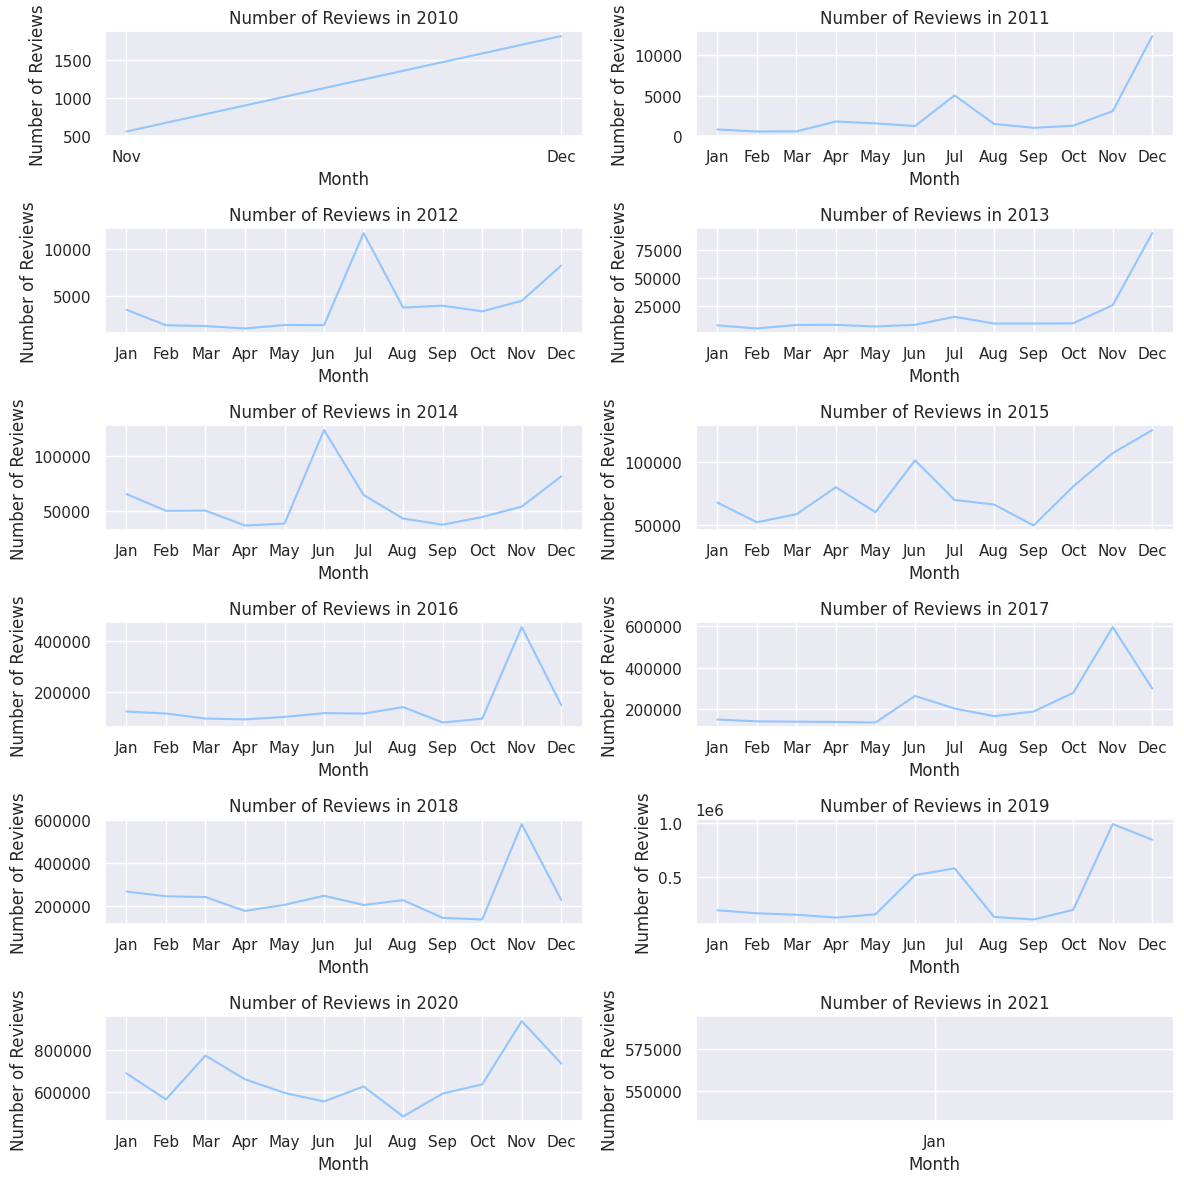

In [27]:
# Function for mapping number of month to its short name
def map_months_index_to_shortname(months):
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    return [month_order[int(month) - 1] for month in months]

# Mapping list of dictionaries with month info by given year
def extract_data_from_year(month_data: dict):
    months = month_data.keys()
    reviews = [month_data[month] for month in months]
    return map_months_index_to_shortname(months), reviews

# Create subplots for each year
fig, axes = plt.subplots(len(monthly_reviews_dict.items()) // 2, 2, figsize=(12, 12))
fig.tight_layout()

# Since some years in dataframe have few months there is a need to
# flatten the axes array
# e.g. in first chunk of 1M records in 2010 there are only 2 months
# when reviews were published; in 2021 has 1 month
if axes.ndim > 1:
    axes = axes.flatten()

for i, year in enumerate(sorted(monthly_reviews_dict.keys())):
    # Unpacking values
    axes[i].plot(*extract_data_from_year(monthly_reviews_dict[year]))
    axes[i].set_title(f'Number of Reviews in {year}')
    axes[i].set_ylabel('Number of Reviews')
    axes[i].set_xlabel('Month')

plt.tight_layout()
plt.show()

**Interpretation of trends**

At the plots below there are **2 noticeble seasonal patterns**: summer and winter.

I can suppose that the total number of reviews is dependent on these two trends by the following reasons:

- <u>summer trend</u>: a lot of student are on holidays and adults are taking a vacation. So people have more spare time to spend on games on Steam and publishing reviews.

- <u>winter trend</u>: people spending more time at home than outdoors and are tending to purchase gifts more for upcoming holidays (games in this case).  


In Google I found the information about <u>the Steam biggest sales</u> and this could also make a significant impact on the total number of the reviews. Why would not buy a game if there is a good discount and not publish a review about your gaming experience?

>As for which Steam sale is biggest, we <u>tend to see the steepest discounts in the Summer and Winter sales</u>, with the Summer sales offering the choicest selection. With Autumn and Winter sales following so close on the heels of Fall release season, there tend to be fewer big, recent titles with hefty discounts.


**Source**: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiI_eav_qyJAxVR0AIHHY7yEAMQFnoECBUQAw&url=https%3A%2F%2Fwww.pcgamer.com%2Fsteam-sale-dates%2F&usg=AOvVaw2TAQfPmbEs0nuuLHS0GvkK&opi=89978449


**Determine if certain times of the year have higher engagement rates. Describe noticeable peaks in user activity.**

For proving my suggestions I need to find the peaks (the most valuable months in years) using `scipy.signal find_peaks` method.

In [28]:
# Parse month number and year from datetime format = "yyyy/mm"
def map_m_y_to_shortname(m_y):
    def get_month(m_y):
        # Reuse mapping function (from month index to its short name)
        return map_months_index_to_shortname([m_y[-1:]])[0]
    def get_year(m_y):
        return m_y[:4]
    return f"{get_month(m_y)}/{get_year(m_y)}"

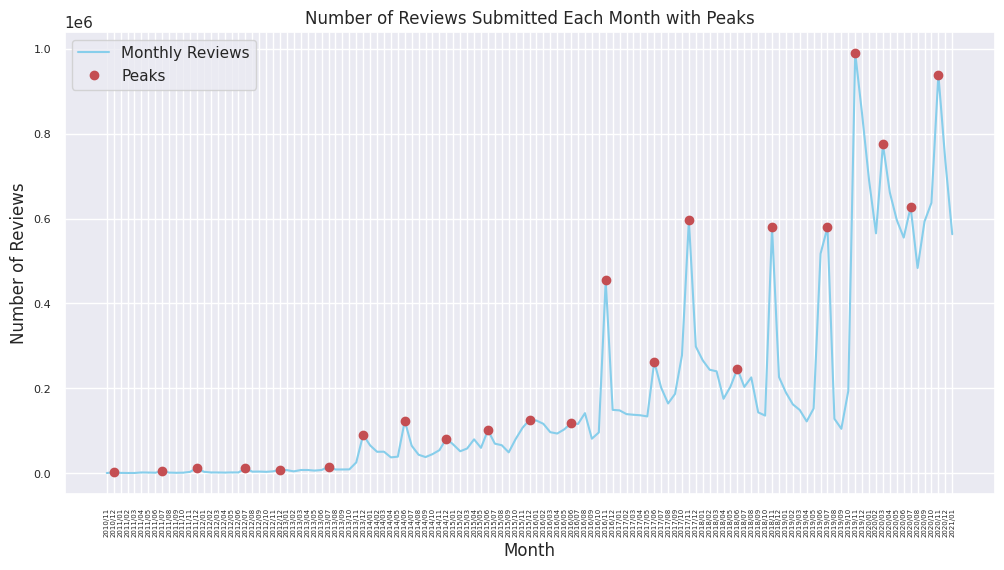

Peak: Feb/2010, Reviews: 1815
Peak: Jul/2011, Reviews: 5051
Peak: Feb/2011, Reviews: 12391
Peak: Jul/2012, Reviews: 11703
Peak: Feb/2012, Reviews: 8236
Peak: Jul/2013, Reviews: 14960
Peak: Feb/2013, Reviews: 90659
Peak: Jun/2014, Reviews: 123071
Peak: Feb/2014, Reviews: 81531
Peak: Jun/2015, Reviews: 101405
Peak: Feb/2015, Reviews: 125625
Peak: Jun/2016, Reviews: 117922
Peak: Jan/2016, Reviews: 454142
Peak: Jun/2017, Reviews: 262547
Peak: Jan/2017, Reviews: 596460
Peak: Jun/2018, Reviews: 246031
Peak: Jan/2018, Reviews: 579586
Peak: Jul/2019, Reviews: 579623
Peak: Jan/2019, Reviews: 990123
Peak: Mar/2020, Reviews: 774675
Peak: Jul/2020, Reviews: 627149
Peak: Jan/2020, Reviews: 939462


In [29]:
# Calculate peaks in the series
# distance = 4 as number of months in a season + 1 month of margin
peaks, _ = find_peaks(monthly_reviews.sort_index(ascending=True), distance=4)

# Plot the data and mark peaks
plt.figure(figsize=(12, 6))
plt.plot(monthly_reviews.index, monthly_reviews.values, label="Monthly Reviews", color="skyblue")
plt.plot(monthly_reviews.index[peaks], monthly_reviews.values[peaks], "ro", label="Peaks")
plt.title("Number of Reviews Submitted Each Month with Peaks")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=90, fontsize=5)
plt.yticks(fontsize=8)
plt.legend()
plt.show()

# Store peaks results
peak_months = monthly_reviews.index[peaks]
peak_values = monthly_reviews.values[peaks]

for m_y, value in zip(peak_months, peak_values):
    print(f"Peak: {map_m_y_to_shortname(m_y)}, Reviews: {value}")

Definately the peak months are varing year out of year but they are placed in bounds of the season:

- <u>summer</u>: June - July;

- <u>winter</u>: January - February.



**Conclusion**

It was discovered the strong seasonal impact on the total number of reviews that were created in mid-summer and mid-winter period.

**What is the most common time of day users write reviews? For example, users might typically write reviews at 17:44. Explain how this time distribution could influence your analysis.**

The most common time of day for users to write reviews is 15:00 - 16:00.


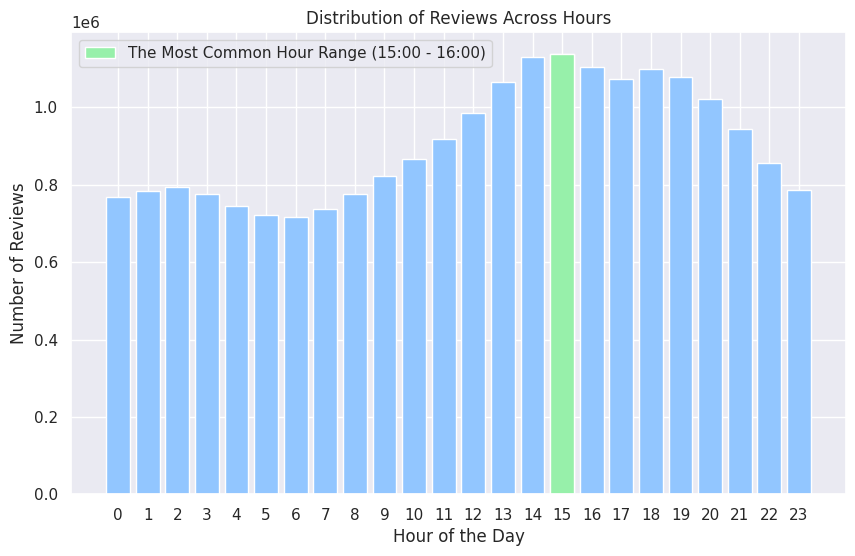

In [30]:
# Create a new Series with the hour when review was created
hour_series = stream_reviews['timestamp_created'].dt.hour

# Group by hour and count the number of reviews
hourly_reviews = stream_reviews.groupby(hour_series, observed=False)['review_id'].count()

# Find the hour with the most reviews
most_common_hour = hourly_reviews.idxmax()
most_common_time_range = f"{most_common_hour}:00 - {(most_common_hour + 1) % 24}:00"

print(f"The most common time of day for users to write reviews is {most_common_time_range}.")

# Plot the distribution of reviews across hours as a bar plot
plt.figure(figsize=(10, 6))
plt.bar(hourly_reviews.index, hourly_reviews.values)
# Highlight the most common hour range
plt.bar(most_common_hour, hourly_reviews[most_common_hour], label=f'The Most Common Hour Range ({most_common_hour}:00 - {(most_common_hour + 1) % 24}:00)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Reviews Across Hours')
plt.xticks(range(24))
plt.legend()
plt.show()

It is more likely users to commit their reviews in evenings and we can use this aspect in analisis that depend on the time of review creation.

**Create a function that accepts a list of time intervals and plots the number of reviews for each interval.**

In [31]:
# Function for printing stats
def print_interval_stats(i, reviews_in_interval):
    print(f"Total number of reviews in {i + 1} interval: {reviews_in_interval}")

# The function that plotting the number of reviews by invervals
def plot_reviews_by_time_intervals(timestamp_created, intervals):
    for i, (start_time, end_time) in enumerate(intervals):
        # Convert start and end times to datetime objects
        start_datetime = pd.to_datetime(start_time).time()
        end_datetime = pd.to_datetime(end_time).time()

        # Search reviews in time range (start_time and end_time) and count them
        reviews_in_interval = timestamp_created[
            (timestamp_created['timestamp_created'].dt.time >= start_datetime) &
            (timestamp_created['timestamp_created'].dt.time <= end_datetime)
        ]['review_id'].count()

        # Print stats of reviews in interval
        print_interval_stats(i, reviews_in_interval)

        # Plot the number of reviews for this interval
        plt.barh(f"{i + 1}: ({start_time} - {end_time})", reviews_in_interval)

    plt.ylabel("Time Interval")
    plt.xlabel("Number of Reviews")
    plt.title("Number of Reviews by Time Interval")
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    plt.tight_layout()
    plt.show()

**Use the function to plot the number of reviews for the following time intervals:**

Total number of reviews in 1 interval: 2347920
Total number of reviews in 2 interval: 2242964
Total number of reviews in 3 interval: 3920327
Total number of reviews in 4 interval: 2967670
Total number of reviews in 5 interval: 3372187
Total number of reviews in 6 interval: 3251708
Total number of reviews in 7 interval: 3610845


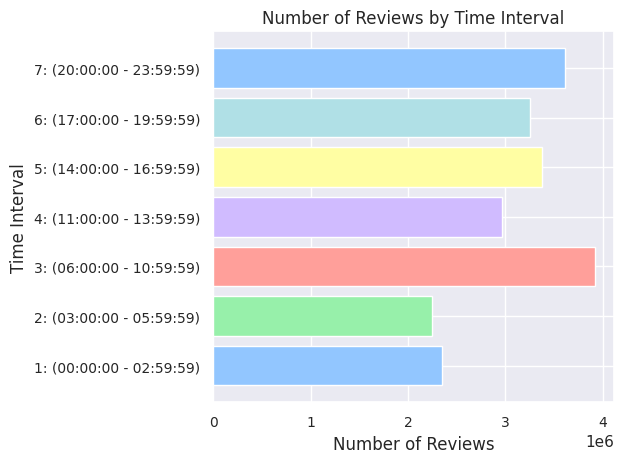

In [32]:
intervals = [
    ('00:00:00', '02:59:59'), # Night
    ('03:00:00', '05:59:59'), # Early Morning
    ('06:00:00', '10:59:59'), # Morning
    ('11:00:00', '13:59:59'), # Early Afternoon
    ('14:00:00', '16:59:59'), # Late Afternoon
    ('17:00:00', '19:59:59'), # Evening
    ('20:00:00', '23:59:59')] # Late Evening

plot_reviews_by_time_intervals(stream_reviews, intervals)

**Summarize your findings from the time interval analysis.**

The users are more likely commmit a review during <u>Late Evening</u> hours (20:00:00 - 23:59:59) and <u>Morning</u> hours (06:00:00 - 10:59:59).

## Research Question 4

[**RQ4**] *Investigating whether users who spend more time using an application give higher or lower ratings.*

   - Analyze the relationship between the amount of time a user has spent on an application and their review score.

   - Do more experienced users (who have used the application longer) tend to give higher or lower ratings? Comment on any trends you observe.

   - Plot the distribution of review scores based on different user experience levels (e.g., new users vs. veteran users). Is there a statistical difference in the score distributions? Use an appropriate statistical test to validate your hypothesis.

   - Ask an LLM tool (ChatGPT, Claude AI, etc.) to interpret the statistical results of the analysis and provide potential explanations for the trends. Does the LLM suggest additional factors that could explain why users who spend more time on the app give higher or lower ratings? How can you validate the interpretations provided by the LLM?

**Analyze the relationship between the amount of time a user has spent on an application and their review score.**

Before running statistical tests that can show the correlation between the amount of time a user has spent on an application and their review score, let's see the plot:

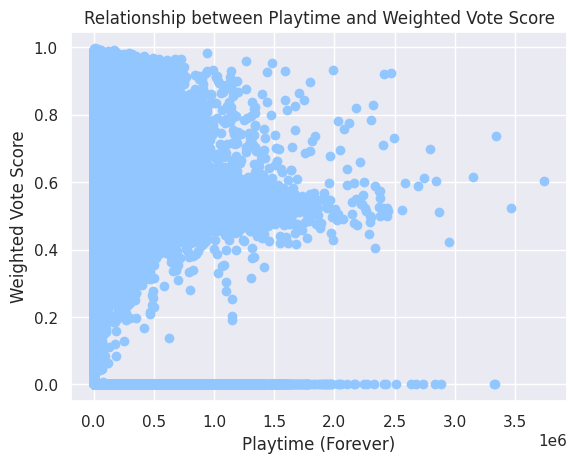

In [33]:
plt.scatter(stream_reviews['author.playtime_forever'], stream_reviews['weighted_vote_score'])
plt.xlabel('Playtime (Forever)')
plt.ylabel('Weighted Vote Score')
plt.title('Relationship between Playtime and Weighted Vote Score')
plt.show()

There is present significant line with `weighted_vote_score = 0.0`. Let's calculate linear and monotonic correlation without exluding outliers:

In [34]:
# Calculate the Pearson correlation
pearson_r, pearson_p = pearsonr(stream_reviews['author.playtime_forever'], stream_reviews['weighted_vote_score'])
print(f"Pearson correlation: {pearson_r}")
print(f"Pearson P-value: {pearson_p}")

# Calculate the Spearman correlation
spearman_r, spearman_p = spearmanr(stream_reviews['author.playtime_forever'], stream_reviews['weighted_vote_score'])
print(f"Spearman correlation: {spearman_r}")
print(f"Spearman P-value: {spearman_p}")

Pearson correlation: 0.04645620052782662
Pearson P-value: 0.0
Spearman correlation: 0.023161755854069446
Spearman P-value: 0.0


**Statistical tests**

**Pearson Correlation**
* *Null Hypothesis $H_0$*: There is no linear correlation between the amount of time a user has spent on an application and their review score ($p = 0$).
* *Alternative Hypothesis $H_1$*: There is a linear correlation between the amount of time a user has spent on an application and their review score ($p \neq 0$).

<u>The Pearson correlation coefficient</u> $r = 0.0465$. The Pearson correlation coefficient indicates a very weak positive linear relationship. This means that as the time spent on the application increases, the review score tends to increase slightly, but the relationship is not strong.

<u>P-value</u> $p = 0.0 < 0.05$ that rejects the null hypothesis in favor of the alternative. The correlation is statically significant. There is a linear relationship between the amount of time a user has spent on an application and their review score in the population at the $α = 0.05$ level. However, the strength of the correlation is so weak (r = 0.0465) that this significance may not imply practical importance.


**Spearman Correlation**
* *Null Hypothesis $H_0$*: There is no monotonic correlation between the number of recommendations and the review scores ($p = 0$).
* *Alternative Hypothesis $H_1$*: There is a monotonic correlation between the number of recommendations and the review scores ($p \neq 0$).

<u>The Spearman correlation coefficient</u> $r_s = 0.0232$. The value of 0.0232 suggests an even weaker relationship compared to the Pearson correlation. This indicates that there is virtually no monotonic relationship between the time spent on the application and the review score.

<u>P-value</u> $p = 0.0 < 0.05$ that rejects the null hypothesis in favor of the alternative. The correlation is statically significant. However, with such a low Spearman correlation coefficient, it indicates that even though there is a statistically significant correlation, it is negligible in terms of practical relevance.

**Conclusion**

Both statistical tests indicate very weak relationships between the time spent on the application and the review scores.



It seems that `weighted_vote_score = 0.0` could be outliers. To check if `weighted_vote_score = 0.0` is an outlier based on its distribution let's visualize it:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


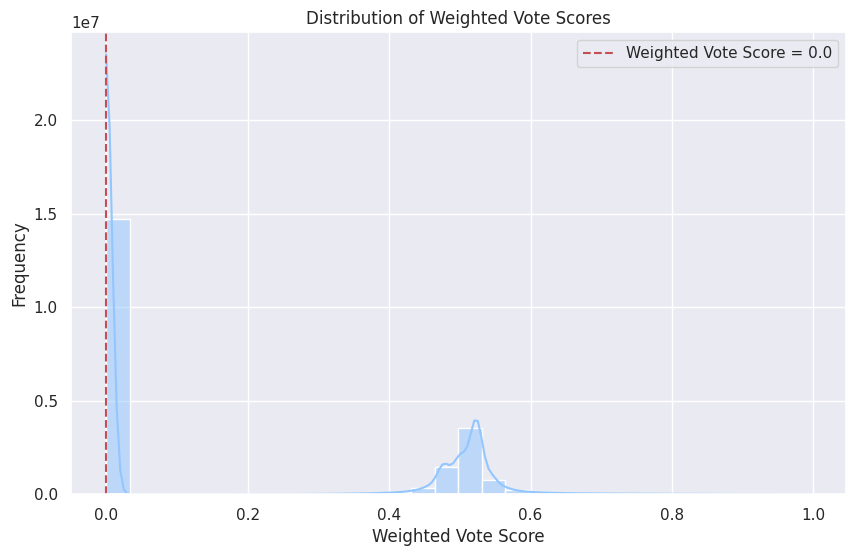

In [35]:
# Visualize the distribution of weighted_vote_score
plt.figure(figsize=(10, 6))
sns.histplot(stream_reviews['weighted_vote_score'], bins=30, kde=True)
plt.axvline(x=0.0, color='r', linestyle='--', label='Weighted Vote Score = 0.0')
plt.xlabel('Weighted Vote Score')
plt.ylabel('Frequency')
plt.title('Distribution of Weighted Vote Scores')
plt.legend()
plt.show()

In [36]:
# Calculate the proportion of 'weighted_vote_score' == 0.0 to the total number of scores
zeros_scores = stream_reviews[stream_reviews['weighted_vote_score'] == 0.0]['weighted_vote_score'].count()
total_scores = stream_reviews.shape[0]
print(f"Percentage of zero weighted_vote_score: {percentage(zeros_scores, total_scores)}")

Percentage of zero weighted_vote_score: 67.89%


Despite the fact that the number of zero `weighted_vote_score` ​​is the majority of the dataset, I will exclude all 0.0 values to investigate the correlation between the amount of time a user has spent on an application and their review score.

In [37]:
# Exclude weighted_vote_score 0.0
non_zero_scores = stream_reviews[stream_reviews['weighted_vote_score'] > 0.0]

Pearson correlation: 0.050558609961776003
Pearson P-value: 0.0
Spearman correlation: 0.11001492238495579
Spearman P-value: 0.0


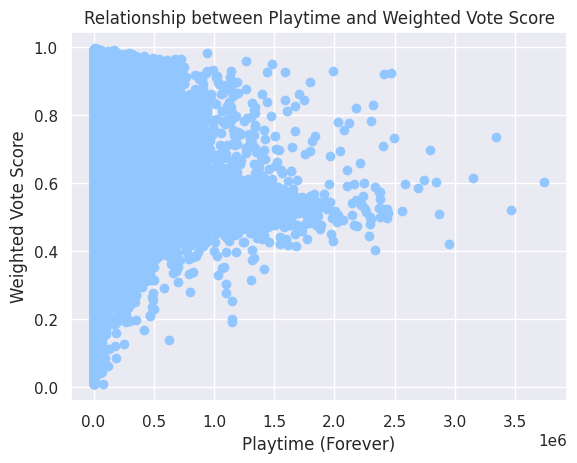

In [38]:
# Calculate the Pearson correlation
pearson_r, pearson_p = pearsonr(non_zero_scores['author.playtime_forever'], non_zero_scores['weighted_vote_score'])
print(f"Pearson correlation: {pearson_r}")
print(f"Pearson P-value: {pearson_p}")

# Calculate the Spearman correlation
spearman_r, spearman_p = spearmanr(non_zero_scores['author.playtime_forever'], non_zero_scores['weighted_vote_score'])
print(f"Spearman correlation: {spearman_r}")
print(f"Spearman P-value: {spearman_p}")

plt.scatter(non_zero_scores['author.playtime_forever'], non_zero_scores['weighted_vote_score'])
plt.xlabel('Playtime (Forever)')
plt.ylabel('Weighted Vote Score')
plt.title('Relationship between Playtime and Weighted Vote Score')
plt.show()

After excluding the outliers the correlation results were slightly improved:
* The Spearman correlation shows a more noticeable improvement, suggesting a better monotonic relationship, although it remains weak.
* The Pearson correlation shows a marginal increase, still reflecting a very weak linear relationship.

**Do more experienced users (who have used the application longer) tend to give higher or lower ratings? Comment on any trends you observe.**

To evaluate the tendency of giving higher or lower ratings I have to answer the question: "Are experienced users more likely to recommend the application (`recommended = True`)?".
Before analysing I would like to break all the users into categories based on their user experience level (*"New User"*, *"Intermediate User"*, *"Veteran User"*) using quantile-based thresholds.

So to dermine the tendency I need to specify if *"Intermediate User"* and *"Veteran User"* more likely to recommend the application in their reviews.

In [39]:
# Define quantile-based thresholds for playtime
quantiles = stream_reviews['author.playtime_forever'].quantile([0.33, 0.66])
low, high = quantiles[0.33], quantiles[0.66]

# Classify users based on playtime
stream_reviews['user_experience_level'] = pd.cut(
    stream_reviews['author.playtime_forever'],
    bins=[-float("inf"), low, high, float("inf")],
    labels=["New User", "Intermediate User", "Veteran User"]
)

/tmp/ipykernel_30/1412595601.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recommendation_rates = stream_reviews.groupby('user_experience_level')['recommended'].mean() * 100


Percentage of recommendations by experience level:
user_experience_level
New User             85.935999
Intermediate User    91.178373
Veteran User         85.318098
Name: recommended, dtype: float64


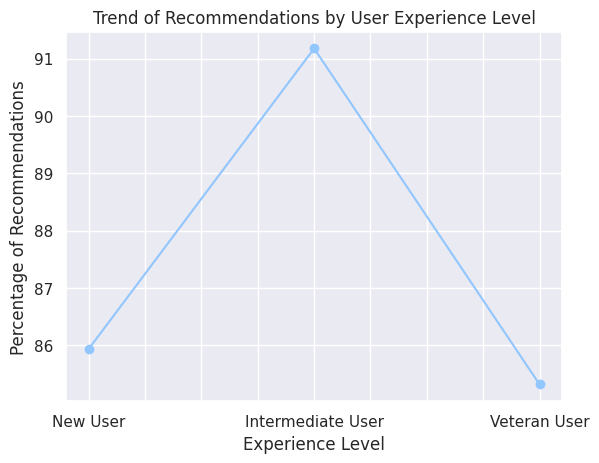

In [40]:
# Group by experience level and calculate the percentage of recommendations
recommendation_rates = stream_reviews.groupby('user_experience_level')['recommended'].mean() * 100

# Sort the recommendation rates by experience level to see if there’s a decreasing trend
recommendation_rates = recommendation_rates.reindex(['New User', 'Intermediate User', 'Veteran User'])

# Display the results
print("Percentage of recommendations by experience level:")
print(recommendation_rates)

# Visualize the trend using a simple line plot to observe any decrease
recommendation_rates.plot(kind='line', marker='o')
plt.xlabel('Experience Level')
plt.ylabel('Percentage of Recommendations')
plt.title('Trend of Recommendations by User Experience Level')
plt.show()

Intermediate Users are most likely to positevely recommend the application (91.18%).

**Plot the distribution of review scores based on different user experience levels (e.g., new users vs. veteran users). Is there a statistical difference in the score distributions? Use an appropriate statistical test to validate your hypothesis.**

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


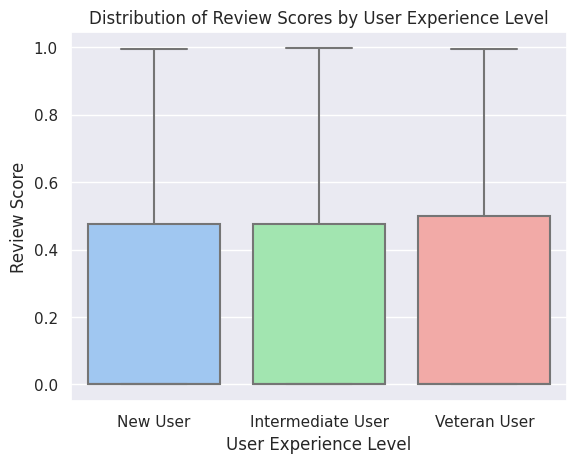

In [41]:
sns.boxplot(x='user_experience_level', y='weighted_vote_score', data=stream_reviews)
plt.xlabel("User Experience Level")
plt.ylabel("Review Score")
plt.title("Distribution of Review Scores by User Experience Level")
plt.show()

For comparison 3 groups of users I choose *The Chi-Squared Test* over `user_experience_level` and `recommended` and *Kruskal–Wallis H test* over `user_experience_level` and `weighted_vote_score` to define the distribution difference of review scores based on different user experience levels.

In [42]:
contingency_table = pd.crosstab(stream_reviews['user_experience_level'], stream_reviews['recommended'])
print("Contingency Table:")
print(contingency_table)

Contingency Table:
recommended              False    True 
user_experience_level                  
New User               1007918  6158734
Intermediate User       632032  6532542
Veteran User           1083876  6298519


**Statistical tests**

**Contingency table**

<u>A contingency table</u> is a type of table in a matrix format that displays the multivariate frequency distribution of the variables.

**Chi-squared test**

<u>A chi-squared test</u> is a statistical hypothesis test used in the analysis of contingency tables when the sample sizes are large. This test is primarily used to examine whether two categorical variables (two dimensions of the contingency table) are independent in influencing the test statistic (values within the table).

* *Null Hypothesis $H_0$*: There is no association between user experience level and likelihood of recommending the app.
* *Alternative Hypothesis $H_1$*: There is an association between user experience level and likelihood of recommending the app.

<u>Chi-Squared value</u>: $Chi^2 = 136338.159$ It is very large value that indicates a large difference between the observed and expected frequencies in contingency table and no association between user experience level and likelihood of recommending the app. 

<u>p-value</u>: $p=0.0 < 0.05 $ The p-value indicates that there is a statistically significant association between `user_experience_level` and their recommendations. This rejects the null hypothesis that there is no association between user experience level and their recommendations.

**Kruskal–Wallis H test**

<u>Kruskal–Wallis H test</u> is a non-parametric statistical test for testing whether samples originate from the same distribution. It is used for comparing two or more independent samples of equal or different sample sizes.

* *Null Hypothesis $H_0$*: The distributions of `weighted_vote_score` are equal across all user experience levels.
* *Alternative Hypothesis $H_1$*: There is a difference in the distributions of `weighted_vote_score` across user experience levels.

<u>Kruskal-Wallis Statistic</u>: $H = 35674.634$ indicates that there are significant differences between the groups in their score distributions.

<u>p-value</u>: $p=0.0 < 0.05 $ The p-value indicates that there is a statistically significant difference in score distributions among the different user experience levels. This rejects the null hypothesis that the distributions of `weighted_vote_score` are equal across all user experience levels.

In [43]:
# Chi-Squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Squared test result: {chi2}")
print(f"P-value: {p}")

Chi-Squared test result: 136338.15940845397
P-value: 0.0


In [44]:
# Kruskal-Wallis test
kruskal_stat, kruskal_p = kruskal(
    stream_reviews[stream_reviews['user_experience_level'] == 'New User']['weighted_vote_score'], 
    stream_reviews[stream_reviews['user_experience_level'] == 'Intermediate User']['weighted_vote_score'], 
    stream_reviews[stream_reviews['user_experience_level'] == 'Veteran User']['weighted_vote_score'])

print(f"Kruskal-Wallis test result: {kruskal_stat}")
print(f"P-value: {kruskal_p}")

Kruskal-Wallis test result: 35674.634815935635
P-value: 0.0


**Ask an LLM tool (ChatGPT, Claude AI, etc.) to interpret the statistical results of the analysis and provide potential explanations for the trends. Does the LLM suggest additional factors that could explain why users who spend more time on the app give higher or lower ratings? How can you validate the interpretations provided by the LLM?**

**ChatGPT gave great explanation about the meaning of test results' large values:**

The high test statistics you observed in both the Chi-Squared test and the Kruskal-Wallis test can be attributed to several factors related to your data and the nature of the tests themselves.

1. *Sample Size*
Large Sample Size: If your dataset contains a large number of observations, even small differences between groups can lead to high test statistics. Both the Chi-Squared and Kruskal-Wallis tests are sensitive to sample size. Larger datasets typically yield more extreme values in the test statistics because they can reveal even minor associations or differences as statistically significant.
2. *Variability in Data*
High Variability: If there is significant variability in the scores or recommendation patterns among the different user experience levels, this can lead to a large test statistic. For the Kruskal-Wallis test, if one group has a significantly different distribution than the others, this will contribute to a higher test statistic.

**ChatGPT Conclusion**
The high test results indicate that there is a strong relationship between user experience levels and app recommendations, as well as significant differences in score distributions across the groups. While high test statistics can indicate a robust finding, it’s crucial to contextualize these results within the overall study design, including sample size and data variability.

**Interpretation of results**

The practical significance shown by <u>Kruskal–Wallis H test</u> (whether this difference is meaningful) can be small even though it's statistically significant due to large sample size. In other words, with 21 million records, even minor score differences are detected as significant.

## Research Question 5

[**RQ5**] *It is interesting to explore the top reviewers to gain insight into their demographic location, the quality of their reviews, and the applications they tend to review most frequently.*

   - Determine the ten reviewers with the highest number of reviews in the dataset.

   - What is the percentage of each language used by these top 10 reviewers when submitting a review?

   - Let's examine whether other users found the reviews from these top 10 reviewers helpful or if they were simply spamming. Calculate the average number of valuable votes these reviewers received for their submitted reviews. Elaborate on the results you see.

   - Create a plot showing the distribution of the number of reviews each application received from the top 10 reviewers, arranged in descending order.

**Determine the ten reviewers with the highest number of reviews in the dataset.**

In [45]:
top_reviewers = stream_reviews.groupby('author.steamid')['review_id'].count().nlargest(10)
top_reviewers

author.steamid
76561198062813911    149
76561198315585536    132
76561198192166873    107
76561198239163744    106
76561198045381877    103
76561198064946151    100
76561198013146396     99
76561198027973295     96
76561197969749884     88
76561197989746995     86
Name: review_id, dtype: int64

**What is the percentage of each language used by these top 10 reviewers when submitting a review?**

In [58]:
top_10_reviewers = top_reviewers.index.tolist()

language_usage = stream_reviews[stream_reviews['author.steamid'].isin(top_10_reviewers)].groupby(['author.steamid', 'language'])['review_id'].count().unstack().fillna(0)

percentage_language_usage = language_usage.div(language_usage.sum(axis=1), axis=0) * 100
percentage_language_usage

language,english,russian,schinese
author.steamid,,,
76561197969749884,100.000000,0.000000,0.000000
76561197989746995,2.325581,0.000000,97.674419
76561198013146396,1.010101,98.989899,0.000000
76561198027973295,0.000000,100.000000,0.000000
76561198045381877,100.000000,0.000000,0.000000
76561198062813911,100.000000,0.000000,0.000000
76561198064946151,100.000000,0.000000,0.000000
76561198192166873,0.000000,0.000000,100.000000
76561198239163744,0.000000,100.000000,0.000000


**Let's examine whether other users found the reviews from these top 10 reviewers helpful or if they were simply spamming. Calculate the average number of valuable votes these reviewers received for their submitted reviews. Elaborate on the results you see.**

In [47]:
# Calculate average helpful votes for each reviewer
average_helpful_votes = stream_reviews[stream_reviews['author.steamid'].isin(top_10_reviewers)].groupby('author.steamid')['votes_helpful'].mean()
average_helpful_votes

author.steamid
76561197969749884    26.238636
76561197989746995    21.058140
76561198013146396     0.969697
76561198027973295    11.802083
76561198045381877     2.252427
76561198062813911     0.885906
76561198064946151     3.990000
76561198192166873    38.897196
76561198239163744     7.641509
76561198315585536    49.712121
Name: votes_helpful, dtype: float64

The average number of valuable votes top 10 reviewers received for their submitted reviews is varing from 50 to 0.8. This mean that only apx. 5 of top reviews has stablily high (over 40) review votes each time.

**Create a plot showing the distribution of the number of reviews each application received from the top 10 reviewers, arranged in descending order.**

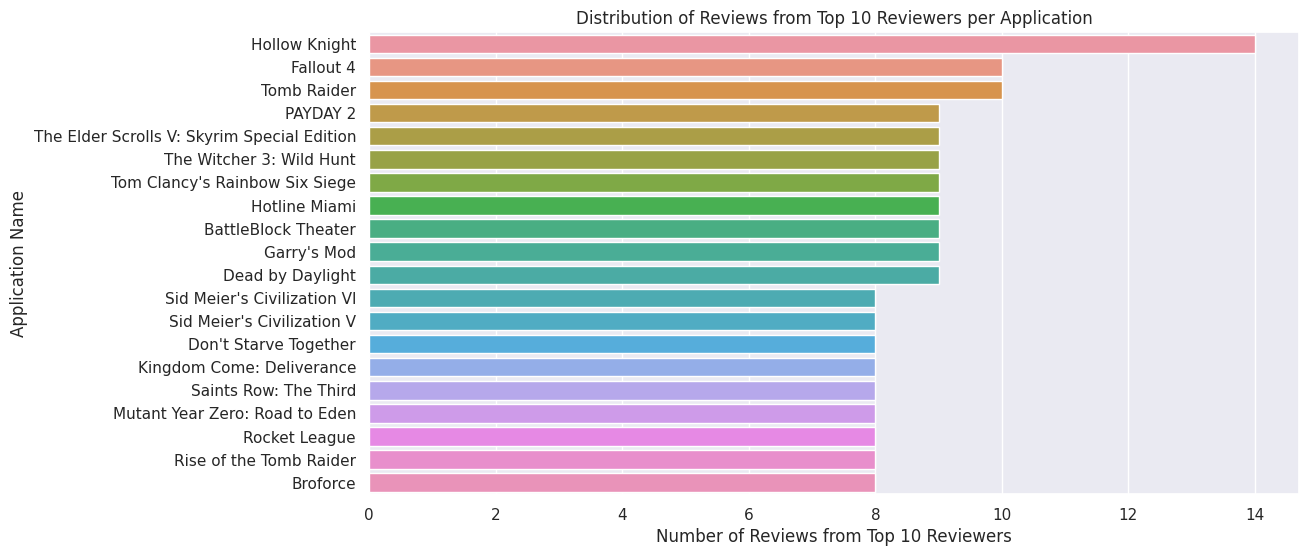

In [48]:
# Filter the dataset to include only reviews from the top 10 reviewers
reviews_from_top_10 = stream_reviews[stream_reviews['author.steamid'].isin(top_10_reviewers)]

# Group by application name and count the number of reviews from the top 10 reviewers
app_review_counts = reviews_from_top_10.groupby('app_name')['review_id'].count()

# Sort the application review counts in descending order
# I took top 20 results to plot
app_review_counts_sorted = app_review_counts.sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=app_review_counts_sorted.values, y=app_review_counts_sorted.index)
plt.xlabel('Number of Reviews from Top 10 Reviewers')
plt.ylabel('Application Name')
plt.title('Distribution of Reviews from Top 10 Reviewers per Application')
plt.show()

## Research Question 6

[**RQ6**] *Let's investigate the behavior of specific groups, specifically focusing on English and Spanish reviewers*



  - Which group is more likely to edit or update their review after submitting it? “English or Spanish!”?

  - Provide the average number of games that reviewers from each group have on their Steam accounts and the average number of games for which they write reviews. What can you say about the number you just calculated?

**Which group is more likely to edit or update their review after submitting it? “English or Spanish!”?**

In [49]:
# Create new column 'edit' whether review was updated
stream_reviews['edit'] = (stream_reviews['timestamp_updated'] > stream_reviews['timestamp_created'])

# Filter for English and Spanish reviews
english_reviews = stream_reviews[stream_reviews['language'] == 'english']
spanish_reviews = stream_reviews[stream_reviews['language'] == 'spanish']

# Calculate the proportion of reviews with updated timestamps for each group
english_updated_proportion = len(english_reviews[english_reviews['edit'] == True]) / len(english_reviews)
spanish_updated_proportion = len(spanish_reviews[spanish_reviews['edit'] == True]) / len(spanish_reviews)

# Print proportions
print(f"Proportion of updated English reviews: {english_updated_proportion}")
print(f"Proportion of updated Spanish reviews: {spanish_updated_proportion}")

# Determine which group is more likely to update
if english_updated_proportion > spanish_updated_proportion:
  print("English reviewers are more likely to update their reviews.")
elif spanish_updated_proportion > english_updated_proportion:
  print("Spanish reviewers are more likely to update their reviews.")
else:
  print("Both groups have similar likelihood of updating their reviews.")

Proportion of updated English reviews: 0.11912506506869289
Proportion of updated Spanish reviews: 0.0994270285968846
English reviewers are more likely to update their reviews.


**Provide the average number of games that reviewers from each group have on their Steam accounts and the average number of games for which they write reviews. What can you say about the number you just calculated?**

In [59]:
# Group by language and calculate the average number of games owned and the average number of games reviewed
avg_games_by_group = stream_reviews.groupby('language').agg({'author.num_games_owned': 'mean', 'app_name': 'nunique'})

# Print results
avg_games_by_group.rename(columns={'author.num_games_owned': 'Average Games Owned', 'app_name': 'Average Games Reviewed'})

,Average Games Owned,Average Games Reviewed
language,,
brazilian,1.020125e+02,313
bulgarian,7.026637e+01,245
czech,1.089826e+02,308
danish,7.674267e+01,299
dutch,7.930032e+01,307
english,1.371887e+06,315
finnish,9.623392e+01,306
french,1.247402e+02,314
german,1.412360e+02,314


It is likely to observe the same average number of games by each language group of reviewers. The biggest games "owners" are users that write their reviews in English, Russian and Schinese.

## Research Question 7

[**RQ7**] *Certainly, calculating probabilities and conducting statistical tests are essential skills for any data scientist. Let's calculate some intriguing figures.*

   - What is the probability of submitting a review and receiving at least one helpful vote from other users?

   - What is the probability of submitting a review and receiving at least one helpful vote from other users, given that you don’t recommend the app?

   - Is the probability of “a review receiving at least one helpful vote” independent of the probability that “the reviewer has submitted at least five reviews before the current review”? Elaborate on it.

   - We hypothesize that “reviewers who own a larger number of games are likely to leave fewer reviews on the platform.” Please validate or refute this statement through statistical analysis.

   - Ask an LLM tool (such as ChatGPT, Claude AI, Gemini, Perplexity, etc.) to understand the purposes of histograms, bar plots, scatterplots, and pie charts and what kind of insights they offer that might be useful for statistical analysis. Are those results trustworthy, or can you do something to improve somehow the confidence in the suggestions given by the LLM?

**What is the probability of submitting a review and receiving at least one helpful vote from other users?**

**Events definition**
* $A$: is the event that a review receives at least one helpful vote.

* $B$: is the event that a review receives 0 helpful vote (votes_helpful = 0).

In [51]:
# (1 - probability of review has 0 as votes_helpful)
# P(A) = 1 - P(B)
total_reviews = len(stream_reviews)
reviews_with_not_helpful_votes = len(stream_reviews[stream_reviews['votes_helpful'] == 0])
probability_at_least_one_helpful_vote = 1 - (reviews_with_not_helpful_votes / total_reviews)
print(f"The probability of submitting a review and receiving at least one helpful vote is: {probability_at_least_one_helpful_vote}")

The probability of submitting a review and receiving at least one helpful vote is: 0.28106399204444066


**What is the probability of submitting a review and receiving at least one helpful vote from other users, given that you don’t recommend the app?**

**Events definition**
* $A$: is the event that a review receives at least one helpful vote.

* $B$: is the event that the review does not recommend the game (recommended = False).

In [60]:
# Calculate P(B): Probability of not recommending the game
reviews_not_recommended = stream_reviews[stream_reviews['recommended'] == False]
probability_not_recommended = len(reviews_not_recommended) / total_reviews

# Calculate P(A ∩ B): Probability of receiving at least one helpful vote and not recommending the game
reviews_helpful_and_not_recommended = stream_reviews[(stream_reviews['votes_helpful'] > 0) & (stream_reviews['recommended'] == False)]
P_A_and_B = len(reviews_helpful_and_not_recommended) / total_reviews

**Check if A and B are independent**

To find conditional probability there is a need to check if events are independent.

In [61]:
# Check for independence
independent = P_A_and_B == probability_at_least_one_helpful_vote * probability_not_recommended

# Print results
print("P(A):", probability_at_least_one_helpful_vote)
print("P(B):", probability_not_recommended)
print("P(A ∩ B):", P_A_and_B)
print("P(A) * P(B):", probability_at_least_one_helpful_vote * probability_not_recommended)
print("Are A and B independent?", independent)

P(A): 0.28106399204444066
P(B): 0.12544319531044593
P(A ∩ B): 0.060804782399029624
P(A) * P(B): 0.03525756524876439
Are A and B independent? False


In [62]:
# P(A∣B) = P(A∩B) / P(B)
# Calculate P(A|B)
if probability_not_recommended > 0:
  conditional_probability = P_A_and_B / probability_not_recommended
  print(f"The probability of receiving at least one helpful vote given that the review does not recommend the game is: {conditional_probability}")
else:
  print("No reviews found where the game was not recommended, cannot calculate the conditional probability.")

The probability of receiving at least one helpful vote given that the review does not recommend the game is: 0.4847196553671196


**Is the probability of “a review receiving at least one helpful vote” independent of the probability that “the reviewer has submitted at least five reviews before the current review”? Elaborate on it.**

**Events definition**
* $A$: is the event that a review receiving at least one helpful vote.

* $B$: is the event that the reviewer has submitted at least five reviews before the current review.

In [54]:
# Sort reviews by author.steamid and timestamp_created to process reviews in chronological order
at_least_5_before = stream_reviews.sort_values(by=['author.steamid', 'timestamp_created'])

# Calculate the cumulative count of reviews per user up to each review
at_least_5_before['review_count'] = at_least_5_before.groupby('author.steamid').cumcount()

# Identify reviews where the reviewer has submitted at least 5 reviews before the current review
at_least_5_before['at_least_5_before'] = at_least_5_before['review_count'] >= 5

# Calculate the P(B): the proportion of reviews with at least 5 prior reviews
probability_at_least_five_before = at_least_5_before['at_least_5_before'].mean()

# Print results
print("Probability that the reviewer has submitted at least five reviews before the current review:", probability_at_least_five_before)

Probability that the reviewer has submitted at least five reviews before the current review: 0.07892985697779288


**Check if A and B are independent**

In [55]:
# Calculate P(A ∩ B): Probability of receiving at least one helpful vote and submitting at least five reviews before
reviews_helpful_and_at_least_5_before = stream_reviews[stream_reviews['votes_helpful'] > 0]
reviews_helpful_and_at_least_5_before = reviews_helpful_and_at_least_5_before.merge(
    at_least_5_before[at_least_5_before['at_least_5_before']],
    on=['author.steamid', 'timestamp_created', 'review_id'],
    how='inner'
)
probability_A_and_B = len(reviews_helpful_and_at_least_5_before) / total_reviews

# Check for independence: P(A ∩ B) = P(A) * P(B)
independent = probability_A_and_B == probability_at_least_one_helpful_vote * probability_at_least_five_before

# Print results
print("P(A):", probability_at_least_one_helpful_vote)
print("P(B):", probability_at_least_five_before)
print("P(A ∩ B):", probability_A_and_B)
print("P(A) * P(B):", probability_at_least_one_helpful_vote * probability_at_least_five_before)
print("Are A and B independent?", independent)

if independent:
  print("The probability of a review receiving at least one helpful vote is independent of the probability that the reviewer has submitted at least five reviews before the current review.")
else:
  print("The probability of a review receiving at least one helpful vote is NOT independent of the probability that the reviewer has submitted at least five reviews before the current review.")

P(A): 0.28106399204444066
P(B): 0.07892985697779288
P(A ∩ B): 0.030183173962555578
P(A) * P(B): 0.02218434069367522
Are A and B independent? False
The probability of a review receiving at least one helpful vote is NOT independent of the probability that the reviewer has submitted at least five reviews before the current review.


**We hypothesize that “reviewers who own a larger number of games are likely to leave fewer reviews on the platform.” Please validate or refute this statement through statistical analysis.**

In [65]:
# Duplex of 'author.steamid', 'author.num_games_owned' whre timestamp_updated is the last
latest_games_owned = (stream_reviews.sort_values(by=['author.steamid', 'timestamp_updated'])
      .groupby('author.steamid')
      .tail(1)[['author.steamid', 'author.num_games_owned']])

# Get total number of reviews by user
review_counts = stream_reviews.groupby('author.steamid')['review_id'].count().rename('num_reviews').reset_index()

# Merge the latest number of games owned with the review counts
user_stats = latest_games_owned.merge(review_counts, on='author.steamid')

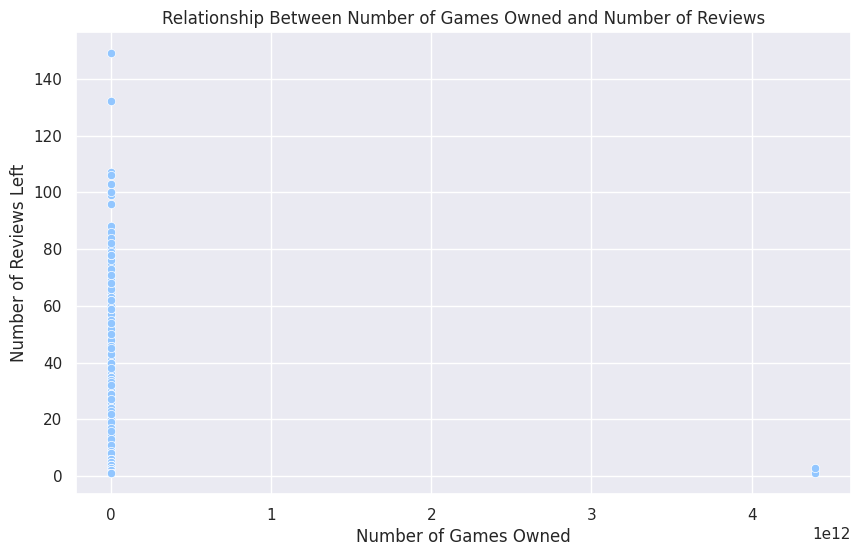

In [96]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_stats, x='author.num_games_owned', y='num_reviews')
plt.xlabel('Number of Games Owned')
plt.ylabel('Number of Reviews Left')
plt.title('Relationship Between Number of Games Owned and Number of Reviews')
plt.show()

In [94]:
spearman_r, spearman_p = spearmanr(user_stats['author.num_games_owned'], user_stats['num_reviews'])
print(f"Spearman correlation: {spearman_r}")
print(f"P-value: {spearman_p}")

Spearman correlation: 0.355056721795949
P-value: 0.0


**Statistical tests**

**Spearman Correlation**
* *Null Hypothesis $H_0$*: There is no correlation between the number of games owned by reviewers and the number of reviews they leave.
* *Alternative Hypothesis $H_1$*: There is a correlation between the number of games owned by reviewers and the number of reviews they leave.

<u>The Spearman correlation coefficient</u> $r_s = 0.355$. The Spearman correlation coefficient measures the strength and direction of the association. The value suggests that there is a moderate positive correlation. This indicates that, generally, as reviewers own more games, they tend to leave more reviews, but the relationship is not very strong.

<u>P-value</u> $p = 0.0 < 0.05$ is statically significant and rejects the null hypothesis (which states that there is no correlation).

**Conclusion**

The Spearman correlation shows a significant, moderate positive correlation between the number of games owned and the number of reviews left. While owning more games tends to be associated with leaving more reviews, the relationship is not strong.

So I **refute** initial statement.

**Ask an LLM tool (such as ChatGPT, Claude AI, Gemini, Perplexity, etc.) to understand the purposes of histograms, bar plots, scatterplots, and pie charts and what kind of insights they offer that might be useful for statistical analysis. Are those results trustworthy, or can you do something to improve somehow the confidence in the suggestions given by the LLM?**

To improve the confidence in the suggestions given by the LLM I can give more information about a specific case and find side sources to aprove or disagree LLM suggestions.

# Algorithmic Question (AQ)

You are given two positive integers, $n$ (where $1\le n \le 10^9$) and k (where $q \le k \le 100$). Your task is to express $n$ as the sum of $k$ positive integers, all having the same parity (i.e., all have the same remainder when divided by 2, meaning they are either all even or all odd).

In other words, find $a_1, a_2, ..., a_k$ each $a_i \gt 0, n = a_1 + a_2 + ... + a_k$, and all $a_i$ simultaneously are either even or odd.

If it's impossible to represent $n$ in this way, report that no such representation exists.



**Input**



In the first input line, you will receive a number t (where $1 \le t \le 100$), representing the number of test cases. The following $t$ lines will contain two values, $n$ and $k$, corresponding to each test case.



**Output**



For each test case, if it is possible to represent $n$ as the sum of $k$ positive integers, all of the same parity (either all even or all odd), print "YES" and provide the corresponding values of $a_i$ in the next line. If there are multiple valid solutions, you can print any of them. If such a representation is not possible for a given test case, print "NO".



**Examples**

---



**Input**

```

8

10 3

100 4

8 7

97 2

8 8

3 10

5 3

```

**Output**

```

YES

4 2 4

YES

55 5 5 35

NO

NO

YES

1 1 1 1 1 1 1 1

NO

YES

3 1 1

```

1. Implement a Python program to solve the problem above.

2. Please provide an analysis of your code's time complexity using Big O notation.

3. Ask an LLM tool (such as ChatGPT, Claude AI, Gemini, Perplexity, etc.) to evaluate the time complexity of your code using Big O notation. Is the assessment accurate? If it differs from your previous analysis, which would be correct? Please explain your reasoning.

**Cases explanation with examples**



Description of the cases (`"YES"`/`"NO"`):

- n and k have the same parity (`"YES"`):

    - odd:

$$n = 5, k = 3$$

$$n/k = 5 / 3 = 1.3$$

$$rest = n - (n//k) * (k-1) = 5 - 1*2=3$$

$$n = 1 + 1 + 3 = 5$$

    - even:

$$n = 86, k = 4$$

$$n/k = 86 / 4 = 21.5$$

$$rest = n - (n//k) * (k-1) = 86 - 21*3=23$$

$$n = 21 + 21 + 21 + 23 = 86$$



- $n$ is even and $k$ is odd (`"YES"`/`"NO"`):

    - For this case it is important to do primary check of the smallest possible sum of $k$ even integers to obtain $n$ is $2 * k$. If it is greater than $n$ there is no possibility of break it down.    

        - example 1:

    $$n = 8, k = 7$$

    Primary condition is not satisfied: $$2*k=14>n$$

    The break down with the smallest possible integer:

    $$sum([1, 1, 1, 1, 1, 1, 1])=7$$

        - example 2:

    $$n = 4, k = 3$$

    Primary condition is not satisfied: $$2*k=6>n$$

    The break down with the smallest possible integer:

    $$sum([1, 1, 1])=3$$

        - example 3:

    $$n = 6, k = 3$$

    Primary condition is satisfied: $$2*k=6=n$$

    The break down with 2:  

    $$sum([2, 2, 2])=6$$



- $n$ is odd and $k$ is even (`"NO"`):

    - It is not possible to breakdown odd number into even number of pieces. The sum of even number is always even. For $k=2$ is

    $$Odd + Odd = Even$$

    $$Even + Even = Even$$



- $k$ is larger than $n$ (`"NO"`).

In [97]:
import math

def get_last_closest_whole(fraction: float):
    return math.floor(fraction)

def get_result(n: int, k: int):
    print("YES")
    # result of division is whole
    if n % k == 0: return [int(n / k)] * k
    # is not whole
    else:
        whole = get_last_closest_whole(n / k)
        result = [whole] * (k - 1)
        rest = n - sum(result)
        return result + [rest]

def express_as_sum(n: int, k: int):
    # case: k is bigger than n
    if n < k: print("NO")
    # case: n is odd and k is even
    elif n % 2 == 1 and k % 2 == 0: print("NO")
    # 1. case: both even or odd
    if n % 2 ==  k % 2: print(*get_result(n, k))
    # case: n is even and k is odd
    elif n % 2 == 0 and k % 2 == 1:
        # primary check:
        if n < 2 * k: print("NO")
        else: print(*get_result(n, k))

In [98]:
for i in range(int(input())):
    n, k = map(int, input().split())
    express_as_sum(n, k)

 7
 10 3


YES
3 3 4


 100 4


YES
25 25 25 25


 8 7


NO


 97 2


NO


 8 8


YES
1 1 1 1 1 1 1 1


 3 10


NO


 5 3


YES
1 1 3


**Big-O notation**



Big-O notation is used to describe the performance or complexity of an algorithm. Specifically, it describes the <u>worst-case scenario</u> in terms of time or space complexity.



**Analysis of code's time complexity using Big O notation**



The function `get_result(n: int, k: int)` has a conditional block that operates in loop $k$ and $(k - 1)$ integers that have complexity: $O(k)$ and $O(2(k-1)) + O(k)$.



Big O notation simplifies expressions by removing constants and focusing on the largest contributing factor to growth as

$k→∞$. This how it can be simplified: $O(2(k-1)) + O(k)≈O(k)$.



Since both cases result in operations with complexity $O(k)$, the overall complexity of `get_result(n: int, k: int)` is $O(k)$.



The function `express_as_sum(n: int, k: int)` doesn't have own operations that are opereted over O(1) (for if statements) so <u>the overall complexity of the alghorithm is</u> $O(k)$.



**Sources**



- Big O Notation of if statement: https://www.reddit.com/r/learnprogramming/comments/y2mju3/how_does_big_o_work_with_if_statements/?rdt=53077

- Big O Notation Tutorial: https://www.geeksforgeeks.org/analysis-algorithms-big-o-analysis/


**Chat GPT evaluation of the alghoritm time complexity**



- `get_last_closest_whole`. Time Complexity: $O(1)$

    - This function uses `math.floor`, which operates in constant time as it simply rounds down the number. The function does not contain any loops or recursive calls.



- `get_result`. Time Complexity: $O(k)$

    - This function first checks if $n \mod k = 0$, which takes $O(1)$.

    - If $n \mod k \neq 0$, it calls `get_last_closest_whole(n / k)`, which is $O(1)$.

    - The list comprehension `[whole] * (k - 1)` generates a list of $k - 1$ elements, which takes $O(k)$.

    - `sum(result)` also iterates over the list `result` (of length $k - 1$), giving it $O(k)$.

    - Therefore, the total time complexity of `get_result` is $O(k)$.



- `express_as_sum`. Time Complexity: $O(k)$

    - The function has a series of conditional checks, each of which operates in $O(1)$.

    - When get_result(n, k) is called, its time complexity $O(k)$ is incurred.

    - Since get_result is the only operation with complexity $O(k)$, the overall complexity of express_as_sum is $O(k)$.



**Overall Complexity**

The function with the highest time complexity in this code is express_as_sum, which calls get_result, leading to an overall time complexity of: $O(k)$.

LLM tool (Chat GPT) gave the same Big O Notation evaluation as was done by me.